In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications import xception
from keras.layers import Lambda 
from keras.models import Input


input_tensor = Input((299, 299, 3))
x = input_tensor
x = Lambda(xception.preprocess_input)(x)

conv_base = xception.Xception(weights='imagenet',
                              include_top=False,
                              input_tensor=x)

In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator()
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 10, 10, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 10, 10, 2048))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

#test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (20000, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (5000, 10 * 10 * 2048))
#test_features = np.reshape(test_features, (12500, 10 * 10 * 2048))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=10 * 10 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=100,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 547s 27ms/step - loss: 0.0391 - acc: 0.9884 - val_loss: 0.0462 - val_acc: 0.9896
Epoch 2/20
20000/20000 [==============================] - 556s 28ms/step - loss: 0.0196 - acc: 0.9948 - val_loss: 0.0418 - val_acc: 0.9932
Epoch 3/20
20000/20000 [==============================] - 433s 22ms/step - loss: 0.0129 - acc: 0.9974 - val_loss: 0.0496 - val_acc: 0.9940
Epoch 4/20
20000/20000 [==============================] - 585s 29ms/step - loss: 0.0092 - acc: 0.9983 - val_loss: 0.0557 - val_acc: 0.9932
Epoch 5/20
20000/20000 [==============================] - 499s 25ms/step - loss: 0.0052 - acc: 0.9991 - val_loss: 0.0673 - val_acc: 0.9928
Epoch 6/20
20000/20000 [==============================] - 626s 31ms/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0713 - val_acc: 0.9934
Epoch 7/20
20000/20000 [==============================] - 502s 25ms/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.0

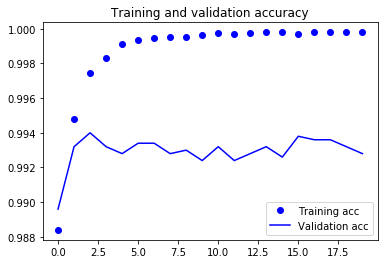

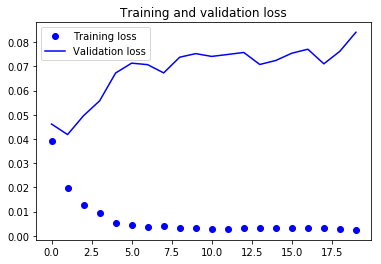

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
from keras.preprocessing import image
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import backend as K

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=predictions)

In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [12]:
for layer in conv_base.layers:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      #rescale=1./255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(299, 299),
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=100,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 529s - loss: 0.2392 - acc: 0.9523 - val_loss: 0.1123 - val_acc: 0.9754
Epoch 2/30
 - 445s - loss: 0.0738 - acc: 0.9820 - val_loss: 0.0931 - val_acc: 0.9714
Epoch 3/30
 - 445s - loss: 0.0546 - acc: 0.9838 - val_loss: 0.0912 - val_acc: 0.9718
Epoch 4/30
 - 445s - loss: 0.0481 - acc: 0.9845 - val_loss: 0.0741 - val_acc: 0.9778
Epoch 5/30
 - 443s - loss: 0.0461 - acc: 0.9849 - val_loss: 0.0707 - val_acc: 0.9794
Epoch 6/30
 - 448s - loss: 0.0446 - acc: 0.9842 - val_loss: 0.0636 - val_acc: 0.9812
Epoch 7/30
 - 441s - loss: 0.0440 - acc: 0.9851 - val_loss: 0.0908 - val_acc: 0.9728
Epoch 8/30
 - 441s - loss: 0.0435 - acc: 0.9854 - val_loss: 0.0905 - val_acc: 0.9726
Epoch 9/30
 - 441s - loss: 0.0406 - acc: 0.9863 - val_loss: 0.0714 - val_acc: 0.9802
Epoch 10/30
 - 445s - loss: 0.0394 - acc: 0.9863 - val_loss: 0.0753 - val_acc: 0.9786
Epoch 11/30
 - 444s - loss: 0.0423 - acc: 0.9847 - val_loss: 0.0938 - val_acc: 0.9720
Epoch 12/30
 - 446s - loss: 0.0405 - acc: 0.9866 - val_loss: 0.

In [15]:
model.save('Xception_feature_extraction.h5')

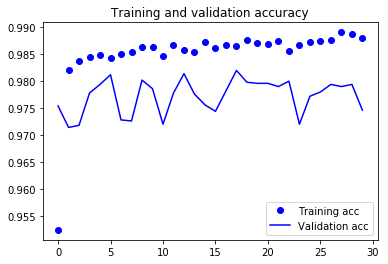

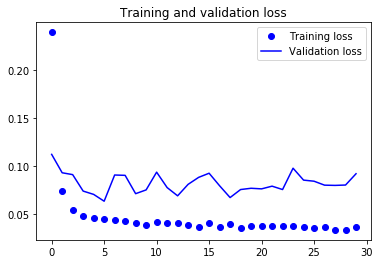

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

In [18]:
for layer in model.layers[:126]:
    layer.trainable = False
for layer in model.layers[126:]:
    layer.trainable = True

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=8)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping])

Epoch 1/100
200/200 [==============================] - 472s 2s/step - loss: 0.0352 - acc: 0.9892 - val_loss: 0.0317 - val_acc: 0.9920
Epoch 2/100
200/200 [==============================] - 446s 2s/step - loss: 0.0312 - acc: 0.9888 - val_loss: 0.0329 - val_acc: 0.9918
Epoch 3/100
200/200 [==============================] - 447s 2s/step - loss: 0.0302 - acc: 0.9893 - val_loss: 0.0338 - val_acc: 0.9912
Epoch 4/100
200/200 [==============================] - 447s 2s/step - loss: 0.0289 - acc: 0.9901 - val_loss: 0.0338 - val_acc: 0.9912
Epoch 5/100
200/200 [==============================] - 446s 2s/step - loss: 0.0268 - acc: 0.9913 - val_loss: 0.0338 - val_acc: 0.9914
Epoch 6/100
200/200 [==============================] - 449s 2s/step - loss: 0.0274 - acc: 0.9902 - val_loss: 0.0349 - val_acc: 0.9910
Epoch 7/100
200/200 [==============================] - 448s 2s/step - loss: 0.0243 - acc: 0.9916 - val_loss: 0.0356 - val_acc: 0.9906
Epoch 8/100
200/200 [==============================] - 453s 2s

In [20]:
model.save('Xception_Finetuning.h5')

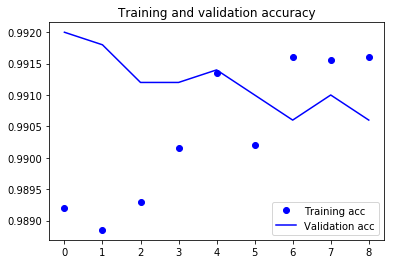

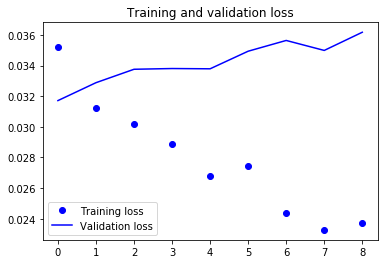

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

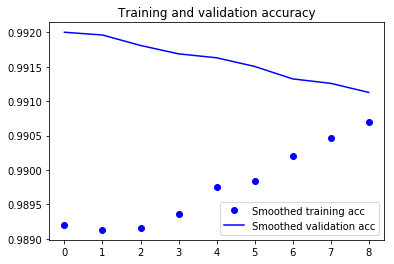

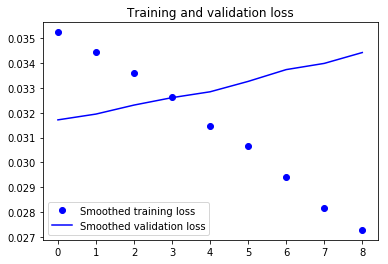

In [22]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=100,
        class_mode=None,
        shuffle=False)

id_batch = test_generator.filenames
print(id_batch[:10])

Found 12500 images belonging to 1 classes.
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [24]:
y_pred = model.predict_generator(generator=test_generator,
                                 steps = 125,
                                 workers=1)

In [25]:
y_pred = y_pred.clip(min=0.005, max=0.995)
y_pred = y_pred.reshape(12500,)

In [26]:
from tqdm import tqdm

with open('Xception_Fintuning.csv','w') as f:
    f.write('id,label\n')
    
with open('Xception_Fintuning.csv','a') as f:
    i = 0
    for img_label in tqdm(y_pred):
        img_name = id_batch[i]
        img_id = int(img_name[img_name.rfind('/')+1:img_name.rfind('.')])
        f.write('{},{}\n'.format(img_id,img_label))
        i+=1

100%|██████████| 12500/12500 [00:00<00:00, 165697.89it/s]
